# imports

In [1]:
import os
import numpy as np
import pandas as pd

from matplotlib import animation
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display

# Paths

In [10]:
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE", ""):
    BASE_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
else:
    BASE_DIR =  'data'

viz_dir = "train"

N_TIMES_BEFORE = 4
# randomly select a record_id from BASE_DIR
record_id = np.random.choice(os.listdir((os.path.join(BASE_DIR,viz_dir))))
# record_id = '1000216489776414077'   # without contrails
# record_id = '1704010292581573769'   # with contrails

- Load the dataset to numpy arrays

In [11]:


with open(os.path.join(BASE_DIR, viz_dir,record_id, 'band_11.npy'), 'rb') as f:  # cloud top phase band (IR)
    band11 = np.load(f)            # (256, 256, 8)  
with open(os.path.join(BASE_DIR,viz_dir, record_id, 'band_14.npy'), 'rb') as f:  # IR longwave Window band (IR)
    band14 = np.load(f)             # (256, 256, 8)
with open(os.path.join(BASE_DIR, viz_dir, record_id, 'band_15.npy'), 'rb') as f:  # "Dirty" Longwave Window Band (IR)
    band15 = np.load(f)            # (256, 256, 8)
with open(os.path.join(BASE_DIR, viz_dir, record_id, 'human_pixel_masks.npy'), 'rb') as f:
    human_pixel_mask = np.load(f)  # (256, 256, 1) # 1: for particular time when anotation was made
with open(os.path.join(BASE_DIR,viz_dir, record_id, 'human_individual_masks.npy'), 'rb') as f:
    human_individual_mask = np.load(f) # (256, 256, 1, 4)  # 4: number of human, 1: for particular time when anotation was made

In [13]:
band11.min()

194.35732

In [15]:
band15.min()

193.24399

## Combine bands into a false color image

In order to view contrails in GOES, we use the "ash" color scheme. This color scheme was originally developed for viewing volcanic ash in the atmosphere but is also useful for viewing thin cirrus, including contrails. In this color scheme, contrails appear in the image as dark blue.

Note that we use a modified version of the ash color scheme here, developed by Kulik et al., which uses slightly different bands and bounds tuned for contrails.

In [4]:
# stack all bands
bands = np.stack([band11, band14, band15], axis=-1)  # (256, 256, 8, 3)

bands.shape

(256, 256, 8, 3)

In [5]:
_T11_BOUNDS = (243, 303) 
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5) 
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
b = normalize_range(band14, _T11_BOUNDS)
false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)  # shape is (256, 256, 3, 8), here t= n_before + n_after + 1 i.e. (4 + 3 + 1)

## Visualize the image

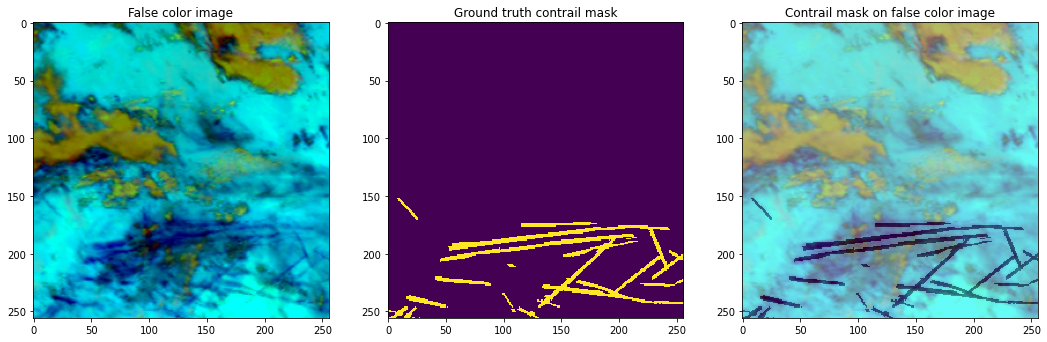

In [6]:
img = false_color[..., N_TIMES_BEFORE]

plt.figure(figsize=(18, 6))
ax = plt.subplot(1, 3, 1)
ax.imshow(img)
ax.set_title('False color image')

ax = plt.subplot(1, 3, 2)
ax.imshow(human_pixel_mask, interpolation='none')
ax.set_title('Ground truth contrail mask')

ax = plt.subplot(1, 3, 3)
ax.imshow(img)
ax.imshow(human_pixel_mask, cmap='Reds', alpha=.4, interpolation='none')
ax.set_title('Contrail mask on false color image');

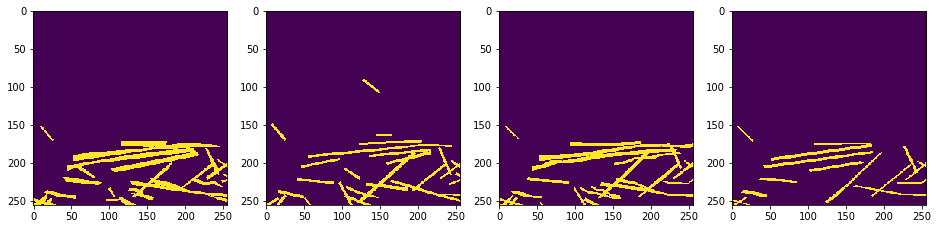

In [7]:
# Individual human masks
n = human_individual_mask.shape[-1]
plt.figure(figsize=(16, 4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(human_individual_mask[..., i], interpolation='none')

In [17]:
# Animation
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(false_color[..., 0])
def draw(i):
    im.set_array(false_color[..., i])
    return [im]
anim = animation.FuncAnimation(
    fig, draw, frames=false_color.shape[-1], interval=500, blit=True
)
plt.close()
display.HTML(anim.to_jshtml())

# EDA

In [13]:
def get_paths(data_type):

    ids_list = os.listdir(os.path.join(BASE_DIR, data_type))

    df = pd.DataFrame(ids_list, columns=['record_id'])

    df['path'] = os.path.join(BASE_DIR, data_type ) +"/"+ df['record_id'].astype(str)

    return df

train_df = get_paths('train')
val_df = get_paths('validation')

In [14]:
def get_mask_image(idx: str, parrent_folder: str) -> np.array:
    return np.load(os.path.join(BASE_DIR, parrent_folder, idx, 'human_pixel_masks.npy')) 

In [15]:
train_images_with_contrails = 0
train_images_without_contrails = 0
train_contrail_pixel_count = 0
train_non_contrail_pixel_count = 0
train_contrail_pixel_count_conly = 0
train_non_contrail_pixel_count_conly = 0
img_pixel_count = 256 * 256

for idx in train_df['record_id']:
    mask = get_mask_image(idx, 'train')
    contrail_pixel_count = np.sum(mask > 0)
    
    if contrail_pixel_count > 0:
        train_images_with_contrails += 1
        train_contrail_pixel_count_conly += contrail_pixel_count
        train_non_contrail_pixel_count_conly += (img_pixel_count - contrail_pixel_count)
    else:
        train_images_without_contrails += 1
        
    train_contrail_pixel_count += contrail_pixel_count
    train_non_contrail_pixel_count += (img_pixel_count - contrail_pixel_count)

In [17]:
validation_images_with_contrails = 0
validation_images_without_contrails = 0
validation_contrail_pixel_count = 0
validation_non_contrail_pixel_count = 0
validation_contrail_pixel_count_conly = 0
validation_non_contrail_pixel_count_conly = 0
img_pixel_count = 256 * 256

for idx in val_df['record_id']:
    mask = get_mask_image(idx, 'validation')
    contrail_pixel_count = np.sum(mask > 0)
    
    if contrail_pixel_count > 0:
        validation_images_with_contrails += 1
        validation_contrail_pixel_count_conly += contrail_pixel_count
        validation_non_contrail_pixel_count_conly += (img_pixel_count - contrail_pixel_count)
    else:
        validation_images_without_contrails += 1
        
    validation_contrail_pixel_count += contrail_pixel_count
    validation_non_contrail_pixel_count += (img_pixel_count - contrail_pixel_count)

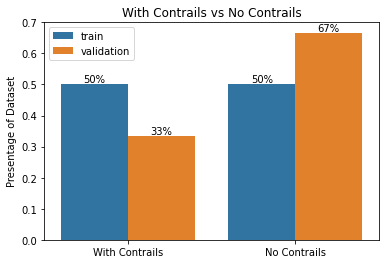

In [20]:
train_with_contrails = train_images_with_contrails / (train_images_with_contrails + train_images_without_contrails)
train_without_contrails = train_images_without_contrails / (train_images_with_contrails + train_images_without_contrails)
validation_with_contrails = validation_images_with_contrails / (validation_images_with_contrails + validation_images_without_contrails)
validation_without_contrails = validation_images_without_contrails / (validation_images_with_contrails + validation_images_without_contrails)
data = pd.DataFrame({'Type': ['With Contrails', 'No Contrails', 'With Contrails', 'No Contrails'],
        'Data': [train_with_contrails, train_without_contrails, validation_with_contrails, validation_without_contrails],
        'Data Set': ['train', 'train', 'validation', 'validation']})

ax = sns.barplot(data=data, y='Data', x="Type", hue="Data Set", orient='v')

for p in ax.patches:
    ax.annotate(format(p.get_height() * 100, '.0f') + '%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
    
ax.set_xlabel('')
ax.set_ylabel('Presentage of Dataset')
ax.set_title('With Contrails vs No Contrails')

plt.legend()
plt.show()

There is a significantly higher percentage of images with contrails in the train dataset than in the validation.

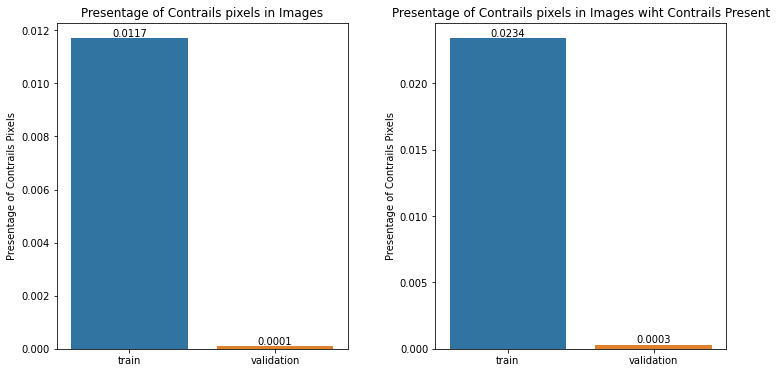

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.3)
axes = axes.flatten()

train_with_contrails_pix = train_contrail_pixel_count / (train_contrail_pixel_count + train_non_contrail_pixel_count)
validation_with_contrails_pix = validation_contrail_pixel_count / (validation_contrail_pixel_count + validation_non_contrail_pixel_count)
data = pd.DataFrame({'Data': [train_with_contrails_pix, validation_with_contrails_pix],
        'Data Set': ['train', 'validation']})
sns.barplot(data=data, y='Data', x="Data Set", orient='v', ax=axes[0])
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
axes[0].set_xlabel('')
axes[0].set_ylabel('Presentage of Contrails Pixels')
axes[0].set_title('Presentage of Contrails pixels in Images')

train_with_contrails_pix_conly = train_contrail_pixel_count_conly / (train_contrail_pixel_count_conly + train_non_contrail_pixel_count_conly)
validation_with_contrails_pix_conly = validation_contrail_pixel_count_conly / (validation_contrail_pixel_count_conly + validation_non_contrail_pixel_count_conly)
data = pd.DataFrame({'Data': [train_with_contrails_pix_conly, validation_with_contrails_pix_conly],
        'Data Set': ['train', 'validation']})
sns.barplot(data=data, y='Data', x="Data Set", orient='v', ax=axes[1])
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
axes[1].set_xlabel('')
axes[1].set_ylabel('Presentage of Contrails Pixels')
axes[1].set_title('Presentage of Contrails pixels in Images wiht Contrails Present')

plt.show()

There is a significant imbalance in the number of pixels between the negative class (non-contrail) and the positive class (contrail). In the training and validation datasets, the ratio of negative to positive class pixels is 85:1 and 164:1 respectively. This severe class imbalance can lead to biased models that prioritize the majority class, ultimately reducing the overall prediction quality.

To address this issue, we can employ two strategies: optimizing the confidence threshold during post-processing or incorporating class weights into the loss function during training.

Optimizing confidence threshold during post-processing:
After training the model, we can adjust the confidence threshold used to determine class predictions. By carefully selecting the threshold, we can increase the sensitivity to the positive class, thereby improving the detection of contrails. This approach allows us to fine-tune the model's predictions without retraining it.

Adding class weights to the loss function during training:
Another way to handle the class imbalance is by assigning appropriate weights to the different classes during model training. By assigning higher weights to the minority class (contrail), we can increase its influence on the loss function. This adjustment ensures that the model pays more attention to the positive class and helps mitigate the bias towards the majority class (non-contrail).

We will use both the techniques.